In [ ]:
import tensorflow as tf
from pathlib import Path
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.layers import Input
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

In [ ]:
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[]


(493, 128, 128, 3)
493
[0 1 2 3 4] [0. 1.] [0. 1.] [0. 1.]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_3 (Dropout)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 40965     
                                                                 
Total params: 14755653 (56.29 MB)
Trainable params: 40965 (160.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/

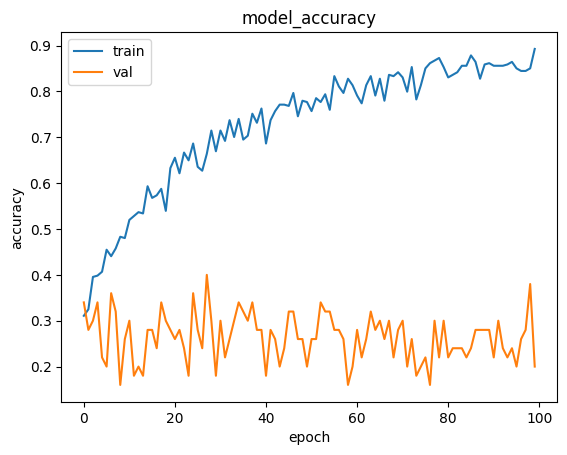

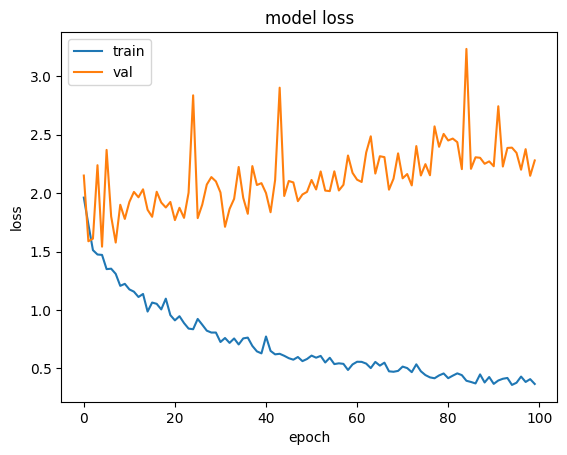

3/3 [==============================] - 18s 5s/step
              precision    recall  f1-score   support

distoangular       0.17      0.33      0.22         9
  horizontal       0.33      0.10      0.15        20
mesioangular       0.27      0.20      0.23        20
  transverse       0.00      0.00      0.00         4
    vertical       0.49      0.58      0.53        36

    accuracy                           0.34        89
   macro avg       0.25      0.24      0.23        89
weighted avg       0.35      0.34      0.32        89

[[ 3  0  1  1  4]
 [ 0  2  7  2  9]
 [ 4  3  4  2  7]
 [ 2  0  0  0  2]
 [ 9  1  3  2 21]]
AUC: 0.6985354437098875


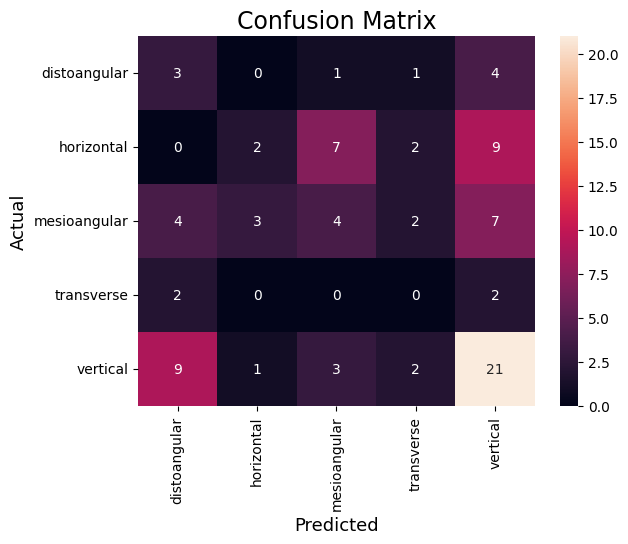

In [ ]:
def load_dataset(dataset_path):
    data = []
    labels = []
    class_names=['distoangular','horizontal','mesioangular','transverse','vertical']

    for class_name in class_names:
        # class_path = dataset_path / class_name
        class_path = os.path.join(dataset_dir, class_name)
        label_encoder = LabelEncoder()
        class_path = Path(class_path)
        image_paths = (list(class_path.glob("*.[jJ][pP][gG]")) + list(class_path.glob("*.[pP][nN][gG]"))) + list(class_path.glob("*.bmp"))

        for image_path in image_paths:
            image = tf.io.read_file(str(image_path))
            image_extension = image_path.suffix.lower()
            if image_extension == '.jpeg' or image_extension == '.jpg':
                image = tf.image.decode_jpeg(image, channels=3)
            elif image_extension == '.png':
                image = tf.image.decode_png(image, channels=3)
            elif image_extension == '.bmp':
                image = tf.image.decode_bmp(image)
            else:
                raise ValueError(f"Unsupported image format: {image_extension}")

            # image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (128,128))
            data.append(image)
            labels.append(class_name)

    data = tf.stack(data)
    # Use the label encoder to transform class names to integers
    labels = label_encoder.fit_transform(labels)

    return data, labels

dataset_dir=r"/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left"

data, labels = load_dataset(dataset_dir)
custom_dataset = tf.data.Dataset.from_tensor_slices((data, labels))

#to confirm the data availability and size
print(data.shape)
print(len(custom_dataset))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(np.array(data), np.array(labels), test_size=0.1, random_state=42)

# Set validation ratio
VALID_PERCENT = 0.2
split_on = int((1 - VALID_PERCENT) * len(x_train))

train_images = x_train[0:split_on,:,:]
train_labels = to_categorical(y_train, num_classes=5)[0:split_on,:]

valid_images = x_train[split_on:,:,:]
valid_labels = to_categorical(y_train, num_classes=5)[split_on:,:]

test_images = x_test
test_labels = to_categorical(y_test, num_classes=5)

# Rescale images
def preprocess(images):
  rescaled_images=images/255
  return rescaled_images

train_img=preprocess(train_images)
valid_img=preprocess(valid_images)
test_img=preprocess(test_images)

print(np.unique(labels), np.unique(train_labels), np.unique(test_labels), np.unique(valid_labels))

# VGG16
IMG_SIZE=(128,128)

# load base model (pretrained model)
vgg16_weight_path = r"/content/drive/MyDrive/FYP 1/thirdmolar_dataset/Pretrained Model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3, )
)

NUM_CLASSES = 5

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='softmax'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

vgg16.summary()

import time
start = time.time()

vgg16_history=vgg16.fit(train_img, train_labels, validation_data=(test_img, test_labels), batch_size=32, epochs=100, verbose=1, shuffle=True)

end = time.time()
print(end - start)

val_loss, val_acc = vgg16.evaluate(valid_img, valid_labels, verbose=2)
print('\nVal accuracy:', val_acc)
print('Val loss:', val_loss)

train_loss, train_acc = vgg16.evaluate(train_img, train_labels, verbose=2)
print('\nTrain accuracy:', train_acc)
print('Train loss:', train_loss)

# Graph for accuracy and loss
def plotgraph(history, model, img, label, a, b, c):
    plt.plot(history.history[a])
    plt.plot(history.history[b])
    plt.title(c)
    plt.ylabel(a)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plotgraph(vgg16_history, vgg16, test_img, test_labels, 'accuracy', 'val_accuracy', 'model_accuracy') #accuracy
plotgraph(vgg16_history, vgg16, test_img, test_labels, 'loss', 'val_loss', 'model loss') #loss

val_pred = vgg16.predict(valid_img)
print(classification_report(np.argmax(valid_labels, axis=1), np.argmax(val_pred, axis=1), target_names = ['distoangular','horizontal','mesioangular','transverse','vertical']))

cm=confusion_matrix(np.argmax(valid_labels, axis=1), np.argmax(val_pred, axis=1))
print(cm)

#AUC Score
auc = roc_auc_score(valid_labels, val_pred)
print('AUC:', auc)

# Confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['distoangular','horizontal','mesioangular','transverse','vertical'],
            yticklabels=['distoangular','horizontal','mesioangular','transverse','vertical'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Predicted',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()